# Baseline output of the water model.

This notebook loads and pre-processes the Pywr water example.

In [15]:
from pywr.model import Model
from pywr.notebook import draw_graph
from pywr.recorders import TablesRecorder
import tables
import pandas
import seaborn
import numpy as np
import os

from matplotlib import pyplot as plt

%matplotlib inline

In [16]:
DATA_PATH = 'data'
JSON_PATH = 'json'
#OUTPUT_PATH = os.path.join('outputs', 'water-only')
OUTPUT_PATH = os.path.join('outputs', 'water-energy')
FIG_PATH = os.path.join(OUTPUT_PATH, 'figures')

## Hydrology data

In [17]:
# Load the hydrology data

flows = {
    'cntr': {},
    'scen': {}
}

with pandas.HDFStore(os.path.join(DATA_PATH, 'catchmod_flows_by_catchment_sub010.h5')) as store:
    
    for key in store.keys():
        catchment, scenario = key.split('_')
        catchment = catchment.replace('/','')
        df = store[key]
        
        flows[scenario][catchment] = df
   


### Catchment comparison

Here we plot a comparison of the different catchment flows for both of scenarios.

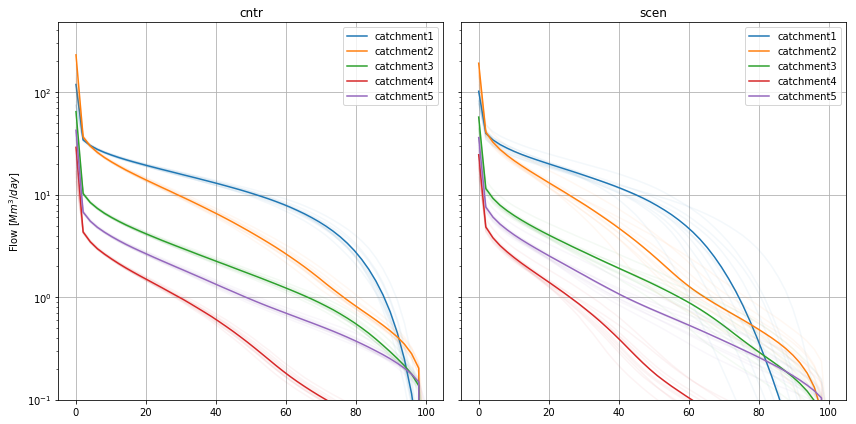

In [18]:
percentiles = np.linspace(0, 100)

fig, axarr = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
palette = seaborn.color_palette()

for ax, scenario in zip(axarr, flows.keys()):
    
    for color, (catchment, flow) in zip(palette, flows[scenario].items()):
        # Plot percentile of each scenario
        q = np.percentile(flow, percentiles, axis=0)
        ax.plot(percentiles, q[::-1, :], alpha=0.05, color=color)
        
        # Plot percentile across all scenarios
        q = np.percentile(flow, percentiles)
        ax.plot(percentiles, q[::-1], alpha=1.0, color=color, label=catchment)
        
    ax.set_title(scenario)
    ax.legend()
    
    
for ax in axarr:
    ax.grid(True)
    ax.set_yscale('log')
    ax.set_ylim(0.1, None)
    
axarr[0].set_ylabel('Flow [$Mm^3/day$]');
    
    
plt.tight_layout()
fig.savefig(os.path.join(FIG_PATH, f'FDC - Catchment comparison.png'), dpi=300)
fig.savefig(os.path.join(FIG_PATH, f'FDC - Catchment comparison.eps'))    

### Scenario comparison

Here we plot a comparison of each catchment between the two scenarios.

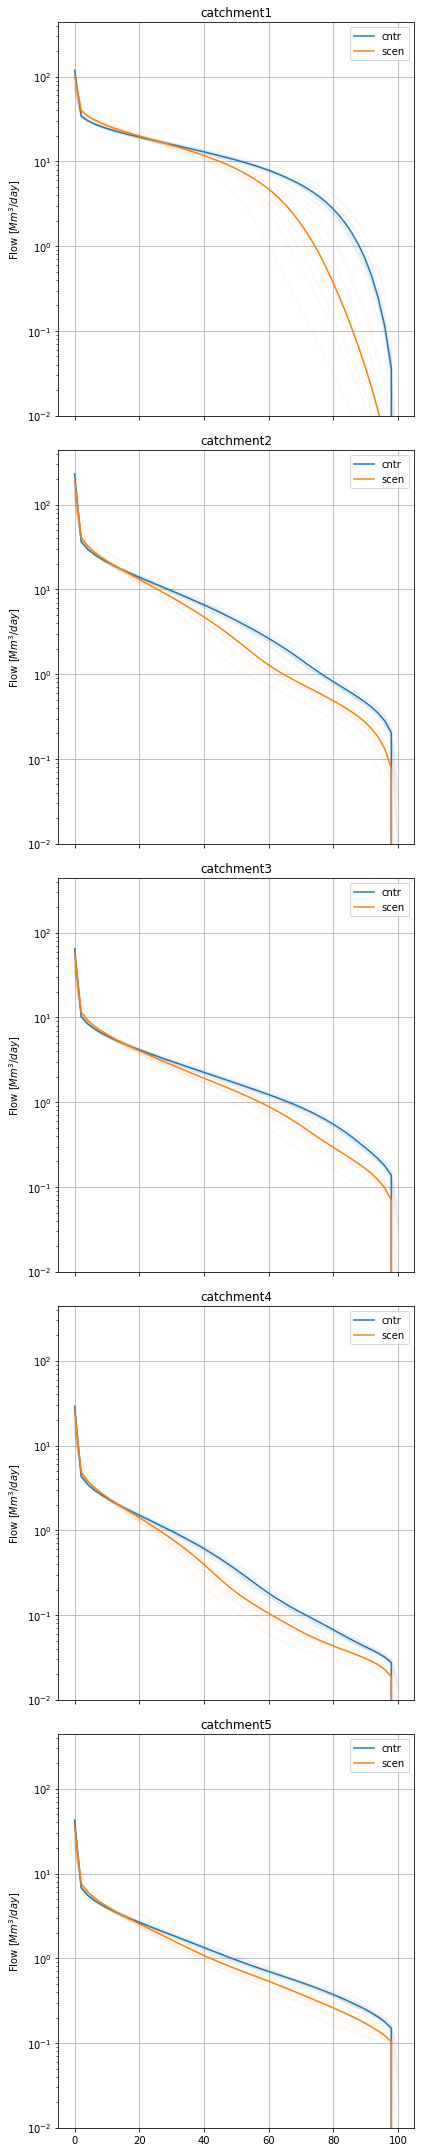

In [19]:
percentiles = np.linspace(0, 100)

ncatchments = 5
fig, axarr = plt.subplots(nrows=ncatchments, figsize=(6, ncatchments*6), sharex=True, sharey=True)
palette = seaborn.color_palette()

for color, scenario in zip(palette, flows.keys()):
    
    for ax, (catchment, flow) in zip(axarr, flows[scenario].items()):

        
        # Plot percentile of each scenario
        q = np.percentile(flow, percentiles, axis=0)
        ax.plot(percentiles, q[::-1, :], alpha=0.05, color=color)
        
        # Plot percentile across all scenarios
        q = np.percentile(flow, percentiles)
        ax.plot(percentiles, q[::-1], alpha=1.0, color=color, label=scenario)
        
        ax.set_title(catchment)

    
for ax in axarr:
    ax.grid(True)
    ax.set_yscale('log')
    ax.set_ylim(0.01, None)
    ax.legend()
    ax.set_ylabel('Flow [$Mm^3/day$]');
    
    
plt.tight_layout()
fig.savefig(os.path.join(FIG_PATH, f'FDC - Scenario comparison.png'), dpi=300)
fig.savefig(os.path.join(FIG_PATH, f'FDC - Scenario comparison.eps'))    

## Water only 

Here we run only the water model and plot some comparison of baseline results.

In [35]:
#model = Model.load(os.path.join(JSON_PATH, 'water_network.json'),)
model = Model.load(os.path.join(JSON_PATH, 'energy_network.json'),)
#model = Model.load(os.path.join(JSON_PATH, 'water_energy_network.json'),)

rec = TablesRecorder(model, os.path.join(OUTPUT_PATH, 'output.h5'))

model.timestepper.end = '2035-01-01'

draw_graph(model)

#for scenario in model.scenarios:
#    print(scenario.name, scenario.size)



<IPython.core.display.Javascript object>

In [36]:
model.run()

,Value
timestep,2035-01-01 00:00:00
timesteps,7306
time_taken,5.56781
time_taken_with_overhead,5.63278
speed,1312.01
num_scenarios,1
solver_name,glpk
version,1.0.1.dev7+gb2cc21a
git_hash,b2cc21a7a237e1ca17f40ba510abddbd29deada0
solver_stats.total,0.259448


In [37]:
data = {}
for rec in model.recorders:
    try:
        data[rec.name] = np.array(rec.values()) 
    except NotImplementedError:
        pass
    
    
pandas.DataFrame(data).T

,0
thermal1_capex,1250.0
thermal2_capex,500.0
thermal3_capex,1250.0
turbine1_capex,1250.0
turbine2_capex,1250.0
transmission_capex,2250.0
energy_total_capex,7750.0
thermal1_opex,0.0
thermal2_opex,292240000.0
thermal3_opex,0.0


In [23]:


with tables.open_file(os.path.join(OUTPUT_PATH, 'output.h5')) as h5:
#    print(h5)
    
    tbl = h5.get_node('/time')
    date_index = pandas.to_datetime({k: tbl.col(k) for k in ('year', 'month', 'day')})
    
    data = {}
    for ca in h5.walk_nodes('/', 'CArray'):
        data[ca._v_name] = pandas.DataFrame(ca.read(), index=date_index, columns=model.scenarios.multiindex)

    
#df = pandas.DataFrame(data, index=date_index)

df = pandas.concat(data, axis=1)
#print(df)
nrows = len(df.columns.levels[0])

#df.plot(subplots=True, )
FLOW_UNITS = 'Mm^3'
ENERGY_UNITS = 'MWh' 
PERCENTILES = np.linspace(0, 100)

Y_LABEL_MAP = {
    'catchment1': f'Catchment 1 inflow [${FLOW_UNITS}/day$]',
    'catchment2': f'Catchment 2 inflow [${FLOW_UNITS}/day$]',
    'catchment3': f'Catchment 3 inflow [${FLOW_UNITS}/day$]',
    'catchment4': f'Catchment 4 inflow [${FLOW_UNITS}/day$]',
    'catchment5': f'Catchment 5 inflow [${FLOW_UNITS}/day$]',
    'irrigation1': f'Irrigation Sector 1 [${FLOW_UNITS}/day$]',
    'irrigation2': f'Irrigation Sector 2 [${FLOW_UNITS}/day$]',
    'water_supply1': f'Water Supply [${FLOW_UNITS}/day$]',
    'return_flow1': f'Return Flow [IS1] [${FLOW_UNITS}/day$]',
    'return_flow2': f'Return Flow [IS2] [${FLOW_UNITS}/day$]',
    'reservoir1': f'Reservoir storage 1 [${FLOW_UNITS}$]',
    'reservoir2': f'Reservoir storage 2 [${FLOW_UNITS}$]',
    'turbine1': f'Turbine flow 1 [${FLOW_UNITS}/day$]',
    'turbine2': f'Turbine flow 2 [${FLOW_UNITS}/day$]',
 }


for node in df.columns.levels[0]:
    fig, ax = plt.subplots(nrows=1, figsize=(12, 4))
    df[node].plot(ax=ax, color='grey', alpha=0.5, legend=False)
 #   df[node].plot(ax=ax, color='grey', alpha=0.5, legend=False)
    
    try:
        label = Y_LABEL_MAP[node]
    except KeyError:
        label = node
    
    ax.set_ylabel(label)
    plt.tight_layout()
    fig.savefig(os.path.join(FIG_PATH, f'{node}.png'), dpi=300)
    fig.savefig(os.path.join(FIG_PATH, f'{node}.eps'))

    
    # Plot duration curve
#    fig, ax = plt.subplots(nrows=1, figsize=(12, 4))
    
#    df[node].quantile(PERCENTILES/100).plot(ax=ax)
#    break



ValueError: Duplicated level name: "weather", assigned to level 1, is already used for level 0.